# Introduction to PyTorch part 2

## Class-based Dataset Definition

In [1]:
from torch.utils.data import Dataset
import pandas as pd


class WaterDataset(Dataset):
    def __init__(self, csv_path: str):
        super().__init__()
        df = pd.read_csv(csv_path)
        self.data = df.to_numpy()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx: int):
        features = self.data[idx, :-1]
        label = self.data[idx, -1]
        return features, label

In [2]:
from torch.utils.data import DataLoader

dataset_train = WaterDataset("./data/water_dataset.csv")
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)

In [3]:
features, labels = next(iter(dataloader_train))
print(f"Features: {features}")
print(f"Labels: {labels}")

Features: tensor([[0.5696, 0.5609, 0.2942, 0.6308, 0.6548, 0.6481, 0.6072, 0.5212, 0.7200],
        [0.4441, 0.3745, 0.2609, 0.7938, 0.5316, 0.2458, 0.6938, 0.4835, 0.4745]],
       dtype=torch.float64)
Labels: tensor([0., 0.], dtype=torch.float64)


## Class-based Model Definition

### From this:

In [4]:
from torch import nn


net = nn.Sequential(
    nn.Linear(9, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)

### To this:

In [5]:
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x


net = Net()

### Weight Initialization

In [6]:
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

        # Apply He/Kaiming initialization
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x


net = Net()

### Batch Normalization

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)

        # Apply He/Kaiming initialization
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

## Taining Loop

In [8]:
from torch import nn, optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(10):  # iterate over epochs and training batches
    for features, labels in dataloader_train:
        features = features.float()  # convert features to float32
        labels = labels.float()  # convert labels to float32
        optimizer.zero_grad()  # clear gradients
        outputs = net(features)  # forward pass and get model's output
        loss = criterion(outputs, labels.view(-1, 1))  # compute loss
        loss.backward()  # compute gradients
        optimizer.step()  # update params

### Some options for optimizer

In [9]:
optimizer = optim.SGD(net.parameters(), lr=0.01)  # Stochastic Gradient Descent
optimizer = optim.Adagrad(net.parameters(), lr=0.01)  # Adaptive Gradient
optimizer = optim.RMSprop(net.parameters(), lr=0.01)  # Root Mean Square Propagation
optimizer = optim.Adam(net.parameters(), lr=0.01)  # Adaptive Moment Estimation

### Model Evaluation

In [10]:
import torch
from torchmetrics import Accuracy

acc = Accuracy(task="binary")  # setup accuracy metric


net.eval()  # set model to evaluation mode
with torch.no_grad():  # iterate over test data batches with no gradients
    # for features, labels in dataloader_test:
    for features, labels in dataloader_train:
        features = features.float()  # convert features to float32
        labels = labels.float()  # convert labels to float32
        outputs = net(features)  # pass data to model
        preds = (
            outputs >= 0.5
        ).float()  # compute predicted labels (based on 0.5 treshold)
        acc(preds, labels.view(-1, 1))  # update accuracy metric

accuracy = acc.compute()
print(f"Accuracy: {accuracy}")

Accuracy: 0.5994694828987122


## Image Dataset

Data Source: https://www.kaggle.com/competitions/cloud-type-classification2/data

### Define Image Transformation

In [11]:
from torchvision import transforms


train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # parse to tensor
        transforms.Resize((128, 128)),  # resize to 128x128
    ]
)

### Prepare DataLoader

In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


dataset_train = ImageFolder(
    "./data/cloud-type-classification2", transform=train_transforms
)

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

In [13]:
image, label = next(iter(dataloader_train))
print(image.shape)  # batch size, color channel in RGB, x-axis, y-axis

torch.Size([1, 3, 128, 128])


### Display the Image

In [14]:
image = image.squeeze().permute(1, 2, 0)
print(image.shape)

torch.Size([128, 128, 3])


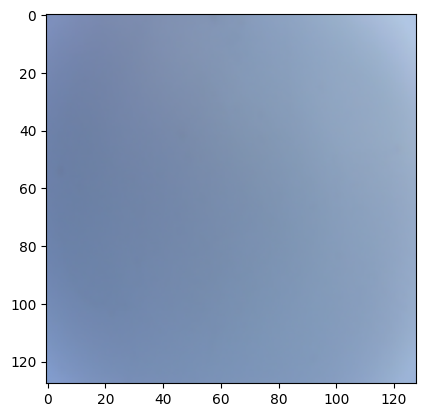

In [15]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()

### Data Augmentation

Generating more data by applying random transformations to original images. <br/>
Objectives:
- Increase the size and diversity of the training set
- Improve model robustness
- Reduce overfitting

In [16]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),  # parse to tensor
        transforms.Resize((128, 128)),  # resize to 128x128
    ]
)


dataset_train = ImageFolder(
    "./data/cloud-type-classification2", transform=train_transforms
)

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

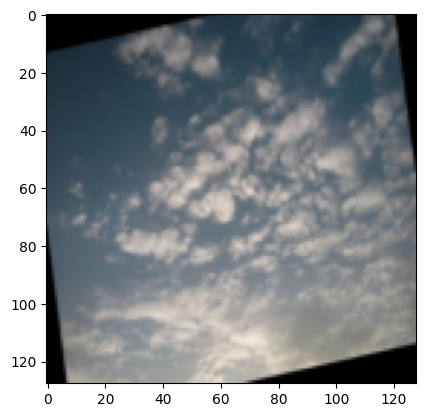

In [17]:
import matplotlib.pyplot as plt


image, label = next(iter(dataloader_train))
image = image.squeeze().permute(1, 2, 0)
plt.imshow(image)
plt.show()

## Convolutional Neural Networks

In [18]:
from torch import nn


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # feture extractor: [convolution, activation, pooling] -> repeated twice and flattened
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )

        # classifier: single linear layer
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        # pass input image through feature extractor and clasifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x